## Importing Libraries

In [1]:
#!/usr/bin/env python3
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from xgboost import XGBClassifier
import import_ipynb


## Preprocessing Class

In [2]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        self._correct_nan_value() #testing commenting out 
        for val in self.df_train.columns:
            total_null = np.sum(self.df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(self.df_train[val].dtype)
                self.list_unique_total.append(len(self.df_train[val].unique()))
                self.list_unique_val.append(self.df_train[val].unique())
                self.list_mode_value.append(self.df_train[val].mode()[0])
                val_counts = max(self.df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(self.df_train))
                val_unique = self.df_train[val].unique()
                self._create_dict(val_unique, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _correct_nan_value(self):
        '''correcting nan string values by converting to np.nan'''
        for col in self.df_train.columns:
            val_total_nan = self.df_train[self.df_train[col]=='nan']
            val_total_nan = val_total_nan.shape[0]
            if val_total_nan > 0:
                index_nan = self.df_train[self.df_train[col]=='nan']
                index_nan = index_nan.index 
                self.df_train.loc[index_nan, col] = np.nan
                
    def _create_dict(self, val_unique, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(self.df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(self.df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, 
                         self.list_unique_total,self.list_mode_value, 
                         self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        '''printing out total columns with null values'''
        val = df_null_info.shape[0]
        print('There are ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv(filepath_files + 'df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                if val == 'P_emaildomain':
                    self.df_train[val] = self.df_train[val].fillna('missing')
                else:
                    val_mode = self.df_train[val].mode()[0]
                    self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        '''dummies encoding and label encoding features'''
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

## Model Class

In [3]:
class Model():
    def __init__(self):
        '''adding and scoring models'''
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        self.dict_results = {'index':[0], 'threshold':[], 'roc_auc_score':[], 
                             'total_cost':[], 'fn':[], 'fp':[]}

    def create_df_score_model(self, model):
        '''scoring model and saving results'''
        print("\nThe following model is being fitted:\n") 
        print(model)
        y_pred, elapsed_time, model = self.add_model(model) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred, model = self._predict(model)
        bool_predict_proba = False
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time, model
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred, model = self._predict_proba(model)
            y_pred = self._predict_proba_threshold(y_pred)
            return y_pred, model
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred, model
        
    def _predict_proba(self, model):
        '''running predict_proba method on model'''
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            return y_pred_prob, model
        except:
            print("Model does not have predict_proba attribute.")

    def _predict_proba_threshold(self, y_pred):
        '''create prediction for each threshold'''
        df_results = pd.DataFrame()
        list_threshold = [.05, .1, .15, .2, .25, .3, 
                          .35, .4, .45, .5, .55, .6]
        for threshold in list_threshold:
            df_temp = self._compute_thres_df(y_pred, threshold)
            df_results = pd.concat([df_results, df_temp], axis=0)
        df_results = df_results.drop('index', axis=1).reset_index(drop=True)
        val_thres_cost, val_thres_auc = self._calc_and_plot_results(df_results)
        y_pred_class = self._y_pred_class(y_pred, val_thres_cost, val_thres_auc)
        print('\nBelow are the results by threshold:\n')
        print(df_results)
        return y_pred_class
        
    def _compute_thres_df(self, y_pred_prob, threshold):
        '''compute the values for each threshold'''
        y_pred_class = binarize(y_pred_prob, threshold)[:,1]
        df_conf_matrix = self._compute_conf_matrix(y_pred_class)
        df_dict_results = self._compute_results(df_conf_matrix, y_pred_class, threshold)
        return df_dict_results
    
    def _compute_conf_matrix(self, y_pred_class):
        '''compute the confusion matrix for the current threshold'''
        conf_matr = confusion_matrix(self.y_test, y_pred_class)
        df_conf_matrix = pd.DataFrame(conf_matr)
        return df_conf_matrix
    
    def _compute_results(self, df_conf_matrix, y_pred_class, threshold):
        '''compute results for each threshold and save to dictionary'''
        val_fn = df_conf_matrix[0][1]
        val_fp = df_conf_matrix[1][0]
        val_cost = val_cost_fn*val_fn + val_cost_fp*val_fp
        val_score = roc_auc_score(self.y_test, y_pred_class)
        self.dict_results.update([('threshold', threshold)])
        self.dict_results.update([('roc_auc_score', val_score)])
        self.dict_results.update([('total_cost', val_cost)])
        self.dict_results.update([('fn', val_fn)])
        self.dict_results.update([('fp', val_fp)])
        df_dict_results = pd.DataFrame.from_dict(self.dict_results)
        return df_dict_results
    
    def _calc_and_plot_results(self, df_results):
        '''plot results and calculate best threshold for auc and cost'''
        self._plot_thres_auc(df_results)
        self._plot_thres_score(df_results)
        val_thres_cost = self._calc_best_thres_cost(df_results)
        val_thres_auc = self._calc_best_thres_auc(df_results)
        return val_thres_cost, val_thres_auc
        
    def _plot_thres_auc(self, df_results):
        '''plot auc roc score by threshold'''
        print('\nThe plot below shows the threshold by auc roc score.\n')
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Auc Roc Score", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Auc Roc Score", fontsize=13)
        plt.plot('threshold', 'roc_auc_score', data=df_results)
        plt.show()

    def _plot_thres_score(self, df_results):
        '''plot cost by threshold'''
        print('The plot below shows the cost by threshold based')
        print('upon the cost of false positive and false negatives.\n')
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Cost", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Cost in Dollars", fontsize=13)
        plt.plot('threshold', 'total_cost', data=df_results)
        plt.show()
    
    def _calc_best_thres_cost(self, df_results):
        '''calculate the best threshold by cost'''
        val_min_cost = df_results.total_cost.min()
        index_min_cost = df_results[df_results.total_cost==val_min_cost].index[0]
        val_threshold_min_cost = df_results.loc[index_min_cost,:].threshold.item()
        print("Best threshold by cost:", val_threshold_min_cost)
        return val_threshold_min_cost

    def _calc_best_thres_auc(self, df_results):
        '''calculate the best threshold by highest auc roc score'''
        val_max_roc_auc = df_results.roc_auc_score.max()
        index_max_roc_auc = df_results[df_results.roc_auc_score==val_max_roc_auc].index[0]
        val_threshold_roc_auc = df_results.loc[index_max_roc_auc,:].threshold.item()
        print("Best threshold by roc auc score:", val_threshold_roc_auc)
        return val_threshold_roc_auc
    
    def _y_pred_class(self, y_pred_prob, val_thres_cost, val_thres_auc):
        '''calculate y_pred_class depending on if we want cost or auc threshold'''
        if bool_thres_cost:
            y_pred_class = binarize(y_pred_prob, val_thres_cost)[:,1]
            return y_pred_class
        else:
            y_pred_class = binarize(y_pred_prob, val_thres_auc)[:,1]
            return y_pred_class

    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time, col_auc = self._calc_scores(y_pred, 
                                                                         elapsed_time) 
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_auc, col_recall, col_precision, 
                             df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_auc = pd.Series(roc_auc_score(mod.y_test, y_pred), name='roc_auc_score')
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print('\nThe best threshold has been automatically selected and scored below.')
        print('roc auc score:', roc_auc_score(mod.y_test, y_pred))
        return col_recall, col_precision, col_time, col_auc
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:")
        print(fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv(filepath_files + 'df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv(filepath_files + 'df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print('\nThe classification report for the current model is shown below.\n')
        print(classif_report)
        print('\nThe last row in the dataframe represents the results of the current model.\n')
        print(df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open(filepath_files + 'df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            self._feat_import_method(model)
        except:
            print("\nThis model does not have the _feature_importance attribute.")
    
    def _feat_import_method(self, model):
        '''run feature importance methods'''
        df_feat_rank = self._feat_import_create_df(model)
        df_feat_rank = self._feat_import_create_plot(df_feat_rank)
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(mod.X_train.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank.reset_index(drop=True)
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        print("\nThe bar chart represents the list of important features in this model.\n")
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        print('\nThe dataframe represents the top 20 features for this model.\n')
        print(df_feat_rank[0:20])

## Feature Engineering Class

In [4]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
#                 bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns:')
        print(self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        self._apply_df_transform(df_feat)
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        '''printing instructions on how to use function'''
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current = LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._sampling_techniques(X_train, y_train)
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
        
    def _sampling_techniques(self, X_train, y_train):
        '''applying resampling techniques and shuffle'''
        X_train, y_train = self._apply_downsampling(X_train, y_train)
        X_train, y_train = self._apply_smote(X_train, y_train)
        X_train, y_train = self._shuffle_df(X_train, y_train)
        return X_train, y_train
    
    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            X_col_names = X.columns
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            X_col_names = X.columns
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            X = self._apply_col_names(X, X_col_names)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
        
    def _apply_col_names(self, X, X_col_names):
        '''adding column names back to dataset'''
        X = pd.DataFrame(X, columns=X_col_names)
        return X
    
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def _convert_to_matrix(self):
        '''converting X_test to matrix so columns match X_train'''
        if bool_apply_downsampling or bool_apply_smote:
            mod.X_test = pd.DataFrame(mod.X_test.values)
            
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if col in df_features.columns:    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        '''aggregate potential new futures for a later time'''
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if non_fraud_total==0:
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat

#### Reading files and merging dataframe

In [5]:
filepath_data = '/Users/krahman/work/fraud_detection/data/'
filepath_files = '/Users/krahman/work/fraud_detection/saved_files/'
train_transaction = pd.read_csv(filepath_data + 'train_transaction.csv')
train_identity = pd.read_csv(filepath_data + 'train_identity.csv')
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

#### Dropping columns with more than 50% missing data

In [6]:
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

#### Grouping columns into lists

In [7]:
# columns beginning with C indicate anonymous information 
# such as how many addresses are associated with card
col_c = [c for c in df_train.columns 
         if c.startswith('C') and (len(c) == 2 or len(c) == 3)]

# columns beginning with D indicate anonymous information  
# such as the amount of time that has passed between transactions
col_d = [d for d in df_train.columns 
         if d.startswith('D') and (len(d) == 2 or len(d) == 3)]

# columns beginning with M indicate anonymous information  
# such as the date of transaction
col_m = [m for m in df_train.columns 
         if m.startswith('M') and (len(m) == 2 or len(m) == 3)]

# columns beginning with V indicate anonymous 
# new features created by Vesta that come in the 
# form of ranking, counting and entity relationships.
col_v = [v for v in df_train.columns 
         if v.startswith('V') and (len(v) == 2 or len(v) == 3 or len(v) == 4)]

# columns beginning with i indicate anonymous information  
# such as the identity information like network and 
# the digital signature associated with transaction
col_i = [i for i in df_train.columns 
         if i.startswith('id_') and len(i) == 5]

# columns beginning with 'card_' indicate anonymous information  
# about the transaction related to card type, credit card company, etc. 
col_card = [ca for ca in df_train.columns 
            if ca.startswith('card')]

#### Setting column id and target

In [8]:
col_id = ['TransactionID']
col_target = 'isFraud'

#### Converting categorical columns with numerical values to object types.

In [9]:
col_cat_to_obj = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

col_cat = ['addr1', 'addr2', 'ProductCD', 'P_emaildomain'] + col_card + col_m

#### Grouping numerical columns

In [10]:
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

#### Setting date column

In [11]:
col_date = ['TransactionDT'] 

#### Total columns

In [12]:
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


#### Instantiating Preprocessing object

In [13]:
pp = Preprocessing()

#### Instantiating Model object

In [14]:
mod = Model()

#### Creating null dataframe

In [15]:
df_null_info = pp.missing_values()

There are 200 columns with null values.


#### Imputing features and saving to csv file

In [16]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv(filepath_files + 'df_imputed.csv')

label encoded: addr1 unique 332
label encoded: addr2 unique 74
dummies encoded: ProductCD unique 5
label encoded: P_emaildomain unique 60
label encoded: card1 unique 13553
label encoded: card2 unique 500
label encoded: card3 unique 114
dummies encoded: card4 unique 4
label encoded: card5 unique 119
dummies encoded: card6 unique 4
dummies encoded: M1 unique 2
dummies encoded: M2 unique 2
dummies encoded: M3 unique 2
dummies encoded: M4 unique 3
dummies encoded: M6 unique 2
new dataframe shape:(590540, 228)


#### Reading preprocessed dataframe

In [17]:
df_features = pd.read_csv(filepath_files + 'df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

#### Instantiating Feature Engineering object

In [18]:
fe = FeatureEngineering()

#### Applying Principal Component Analysis

In [19]:
bool_apply_pca = False

#### Applying Upsampling

In [20]:
bool_apply_smote = True

#### Applying Downsampling

In [21]:
bool_apply_downsampling = True

#### Applying Predict Proba Method

In [22]:
bool_predict_proba = True

#### Creating Tuning Dataframe

In [23]:
bool_create_tuning_df = True

#### Turning on Predict Proba Threshold by Cost

In [24]:
bool_thres_cost = False

#### Setting cost of false positives and false negatives

In [25]:
val_cost_fn = 3000
val_cost_fp = 20

#### Limiting Training Set To 1000 Rows For Debugging

In [26]:
df_feat_1000 = False

#### Creating features (feature engineering)

In [27]:
bool_drop_col = True # dropping original features used to create new features
fe.final_features(bool_drop_col, list_feat=['addr1', 'addr2', 'card2', 
                                            'card3', 'C1', 'P_emaildomain', 
                                            'card6', 'V294', 'V279', 'C14', 
                                            'V306', 'D2', 'D10'])

bool_drop_col = False # keeping original features used to create new features
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 
                                            'D1', 'D3', 'D4', 'D11'])

after running final_features, run create_final_df.
after running final_features, run create_final_df.
keeping original feature card5
keeping original feature V317
keeping original feature V69
keeping original feature D1
keeping original feature D3
keeping original feature D4
keeping original feature D11


#### Appending C4 to list of features to drop

In [28]:
fe.list_drop_col.append('C4')

#### Dropping columns, applying dataframe transformations, creating training and test dataframe

In [29]:
fe.create_final_df()

dropping columns:
['addr1', 'addr2', 'card2', 'card3', 'C1', 'P_emaildomain', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
downsampling applied.
smote applied.
bool_apply_pca set to false.
bool_apply_pca set to false.
creating tuning dataframe...
downsampling applied.
smote applied.
final dataframe created.
To test a model use the mod.create_df_score_model(model_current)
method where, for example, model_current = LogisticRegression().


#### This is used for testing features individually -  commenting out 

In [30]:
# df_feat_1000 = False
# fe.final_features(bool_drop_col, list_feat=['addr1'])
# fe.create_final_df()
# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

## Models Results

### LogisticRegression - Base Score


The following model is being fitted:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

The plot below shows the threshold by auc roc score.



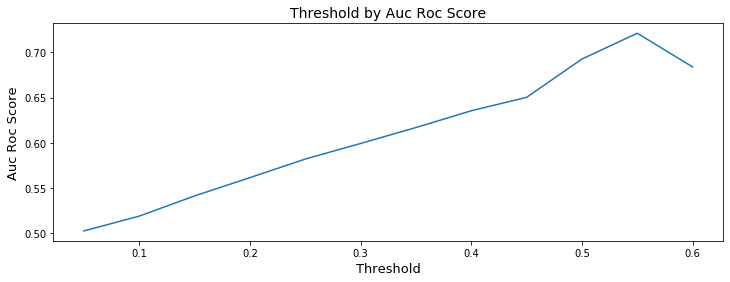

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



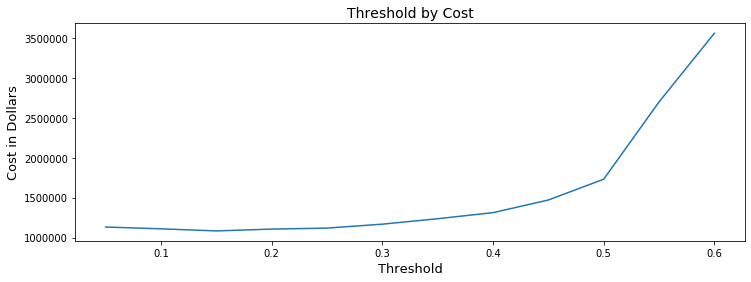

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.55

Below are the results by threshold:

    threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.502722     1132700     0  56635
1        0.10       0.519071     1110220     6  54611
2        0.15       0.541364     1084040    16  51802
3        0.20       0.561594     1106840    44  48742
4        0.25       0.582096     1119180    68  45759
5        0.30       0.599332     1168480   104  42824
6        0.35       0.616927     1236640   148  39632
7        0.40       0.635480     1312460   196  36223
8        0.45       0.650318     1470540   274  32427
9        0.50       0.692647     1730820   419  23691
10       0.55       0.721127     2696680   838   9134
11       0.60       0.683887     3556400  1153   4870

The best threshold has been automatically selected and scored below.
roc auc score: 0.7211274502640596

The following new features have been created:
['addr1_fe', 'addr2_fe', 'card2_fe', 'card

In [31]:
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

### LogisticRegression - Tuned Model


The following model is being fitted:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)

The plot below shows the threshold by auc roc score.



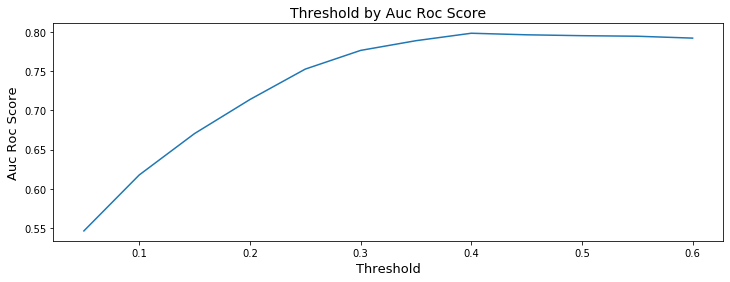

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



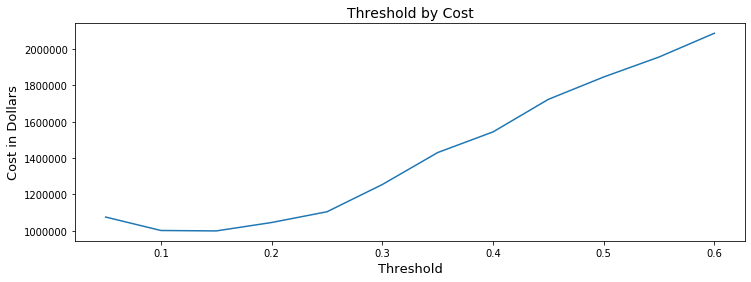

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.4

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.546273     1075320   17  51216
1        0.10       0.617648     1001300   53  42115
2        0.15       0.670497      999000  101  34800
3        0.20       0.713889     1045300  160  28265
4        0.25       0.752707     1104480  220  22224
5        0.30       0.776563     1254320  303  17266
6        0.35       0.788951     1430280  386  13614
7        0.40       0.798469     1543900  441  11045
8        0.45       0.796484     1723080  512   9354
9        0.50       0.795359     1846180  561   8159
10       0.55       0.794648     1956040  605   7052
11       0.60       0.792250     2086960  656   5948

The best threshold has been automatically selected and scored below.
roc auc score: 0.7984685379955978

The classification report for the current model is shown below.

              precision    recall  f1

In [32]:
model_current =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                    intercept_scaling=0.1, l1_ratio=0.01, max_iter=150,
                                    multi_class='auto', n_jobs=-1, penalty='none',
                                    random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                                    warm_start=False)

mod.create_df_score_model(model_current)

### XGBClassifier - Base Model


The following model is being fitted:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

The plot below shows the threshold by auc roc score.



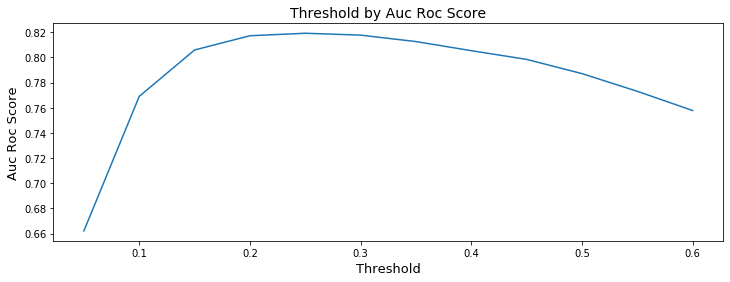

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



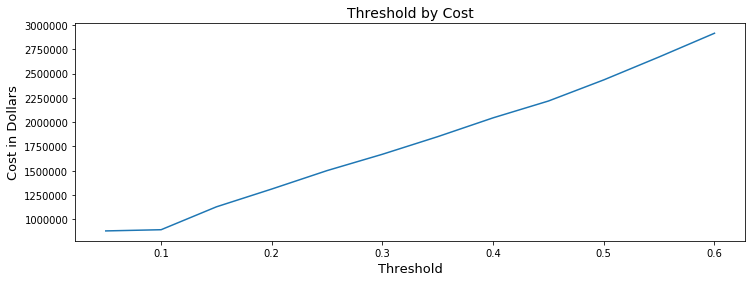

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.662130      880300   45  37265
1        0.10       0.769057      892580  149  22279
2        0.15       0.805916     1128420  279  14571
3        0.20       0.817242     1311720  364  10986
4        0.25       0.819234     1501520  443   8626
5        0.30       0.817741     1669740  510   6987
6        0.35       0.812621     1851140  579   5707
7        0.40       0.805386     2044740  651   4587
8        0.45       0.798457     2217960  715   3648
9        0.50       0.787174     2435540  793   2827
10       0.55       0.773090     2671800  876   2190
11       0.60       0.757829     2915660  961   1633

The best threshold has been automatically selected and scored below.
roc auc score: 0.819234172409212

The classification report for the current model is shown below.

              precision    recall  f1

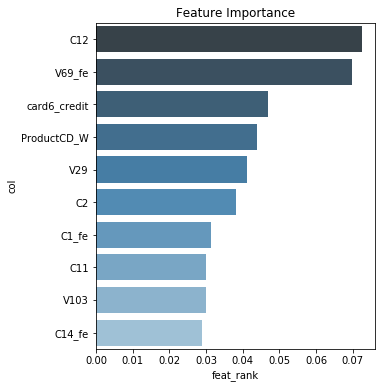


The dataframe represents the top 20 features for this model.

                 col  feat_rank
0                C12   0.072425
1             V69_fe   0.069921
2       card6_credit   0.047008
3        ProductCD_W   0.043823
4                V29   0.041301
5                 C2   0.038276
6              C1_fe   0.031356
7                C11   0.029979
8               V103   0.029896
9             C14_fe   0.028987
10           V317_fe   0.025630
11                C6   0.024823
12               V97   0.024282
13          card2_fe   0.022373
14              V102   0.022326
15               V90   0.021316
16               V34   0.020517
17        card4_visa   0.020478
18  card4_mastercard   0.019181
19           V294_fe   0.018210


In [33]:
model_current = XGBClassifier(n_jobs=-1,random_state=42)
mod.create_df_score_model(model_current)

### XGBClassifier - Tuned Model


The following model is being fitted:

XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)

The plot below shows the threshold by auc roc score.



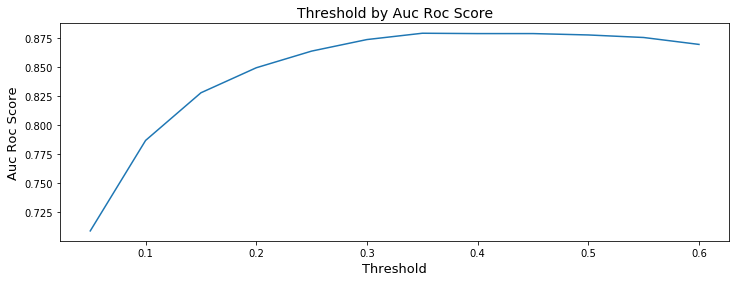

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



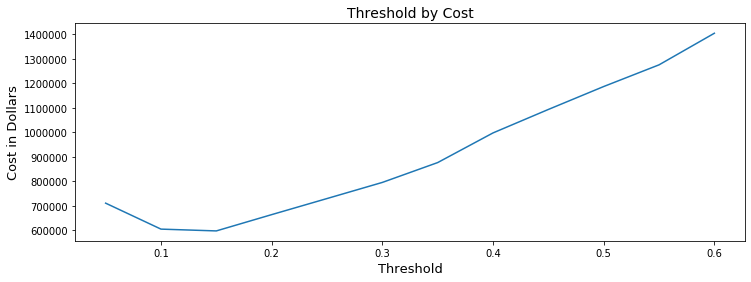

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.35

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.708631      710420   19  32671
1        0.10       0.786539      604300   48  23015
2        0.15       0.827561      596960   83  17398
3        0.20       0.849099      663520  130  13676
4        0.25       0.863437      729260  170  10963
5        0.30       0.873376      795180  206   8859
6        0.35       0.878811      876280  244   7214
7        0.40       0.878512      997500  293   5925
8        0.45       0.878520     1093420  332   4871
9        0.50       0.877335     1187140  369   4007
10       0.55       0.875148     1275760  403   3338
11       0.60       0.869195     1404940  450   2747

The best threshold has been automatically selected and scored below.
roc auc score: 0.87881085793938

The classification report for the current model is shown below.

              precision    recall  f1-

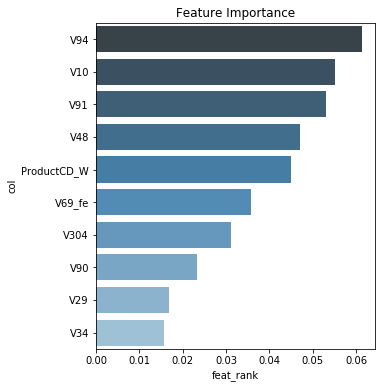


The dataframe represents the top 20 features for this model.

            col  feat_rank
0           V94   0.061307
1           V10   0.055239
2           V91   0.053056
3           V48   0.047171
4   ProductCD_W   0.045013
5        V69_fe   0.035762
6          V304   0.031047
7           V90   0.023429
8           V29   0.016803
9           V34   0.015735
10  card6_debit   0.013519
11          V70   0.013110
12         V302   0.012900
13     card6_fe   0.012871
14          C11   0.010856
15         V303   0.010682
16          V57   0.010559
17      V317_fe   0.009727
18       C14_fe   0.009062
19      V306_fe   0.008814


In [34]:
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)

### RandomForestClassifier - Base Model


The following model is being fitted:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

The plot below shows the threshold by auc roc score.



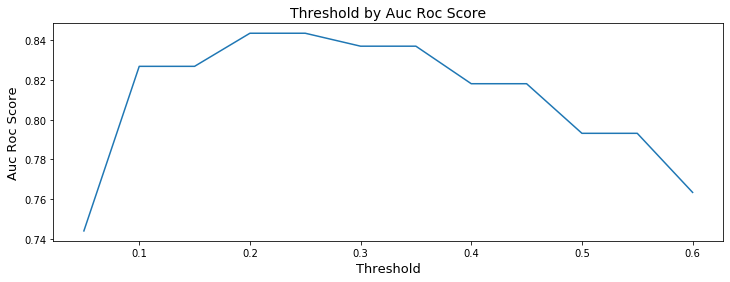

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



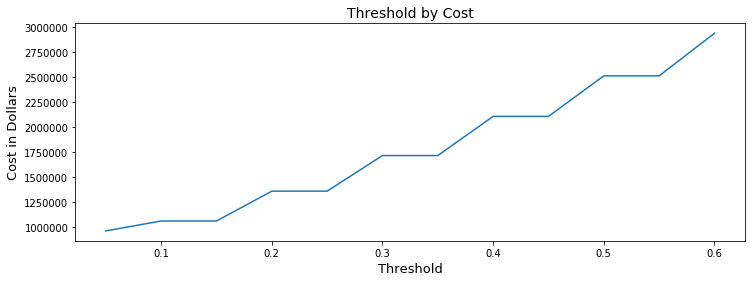

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.744015      959460  153  25023
1        0.10       0.826848     1058600  270  12430
2        0.15       0.826848     1058600  270  12430
3        0.20       0.843504     1357680  407   6834
4        0.25       0.843504     1357680  407   6834
5        0.30       0.836987     1714460  546   3823
6        0.35       0.836987     1714460  546   3823
7        0.40       0.818099     2106800  688   2140
8        0.45       0.818099     2106800  688   2140
9        0.50       0.793136     2512980  830   1149
10       0.55       0.793136     2512980  830   1149
11       0.60       0.763395     2939880  976    594

The best threshold has been automatically selected and scored below.
roc auc score: 0.8435035036885391

The classification report for the current model is shown below.

              precision    recall  f1

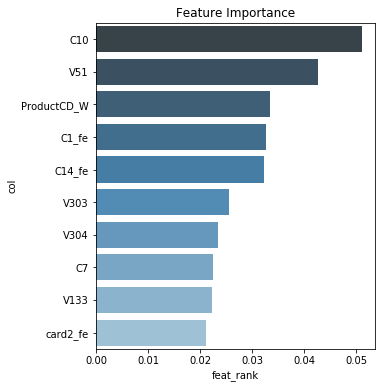


The dataframe represents the top 20 features for this model.

               col  feat_rank
0              C10   0.051003
1              V51   0.042626
2      ProductCD_W   0.033441
3            C1_fe   0.032574
4           C14_fe   0.032208
5             V303   0.025454
6             V304   0.023510
7               C7   0.022547
8             V133   0.022202
9         card2_fe   0.021037
10             V52   0.020420
11             V93   0.019267
12   TransactionDT   0.017133
13            V308   0.016996
14            V295   0.014880
15  TransactionAmt   0.014664
16              C8   0.014516
17             C13   0.014464
18             V30   0.014214
19              C2   0.014144


In [35]:
model_current = RandomForestClassifier(n_jobs=-1, random_state=42)
mod.create_df_score_model(model_current)


### RandomForestClassifier - Tuned Model


The following model is being fitted:

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.0s finished



The plot below shows the threshold by auc roc score.



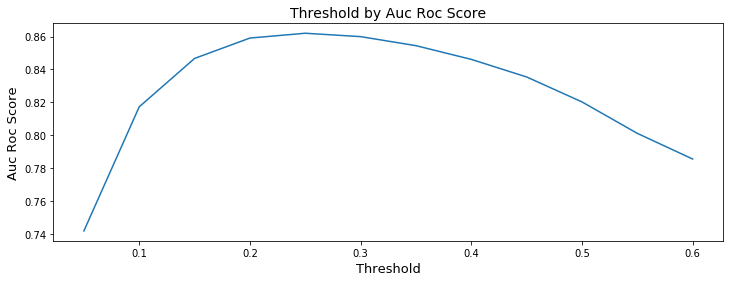

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



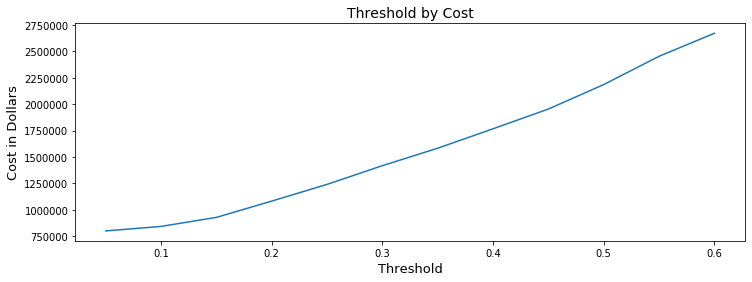

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.741996      801700   87  27035
1        0.10       0.817314      844160  174  16108
2        0.15       0.846683      929780  236  11089
3        0.20       0.859054     1083640  310   7682
4        0.25       0.861978     1241800  377   5540
5        0.30       0.859923     1418680  447   3884
6        0.35       0.854443     1583680  509   2834
7        0.40       0.846119     1767460  576   1973
8        0.45       0.835450     1954120  642   1406
9        0.50       0.820312     2185400  722    970
10       0.55       0.801222     2452740  813    687
11       0.60       0.785645     2670260  887    463

The best threshold has been automatically selected and scored below.
roc auc score: 0.8619777195942564

The classification report for the current model is shown below.

              precision    recall  f

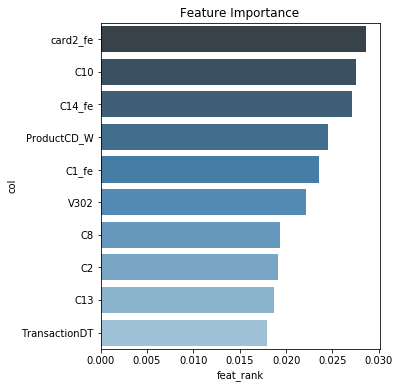


The dataframe represents the top 20 features for this model.

               col  feat_rank
0         card2_fe   0.028645
1              C10   0.027511
2           C14_fe   0.027138
3      ProductCD_W   0.024541
4            C1_fe   0.023530
5             V302   0.022171
6               C8   0.019342
7               C2   0.019174
8              C13   0.018669
9    TransactionDT   0.017935
10         V317_fe   0.017637
11         V306_fe   0.016461
12         V294_fe   0.015677
13  TransactionAmt   0.015576
14            V317   0.015109
15     card6_debit   0.014957
16        card3_fe   0.012879
17             C11   0.012818
18           card1   0.011819
19            V303   0.011627


In [36]:
model_current = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=150,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)

mod.create_df_score_model(model_current)


### CatBoostClassifier - Base Model


The following model is being fitted:


The plot below shows the threshold by auc roc score.



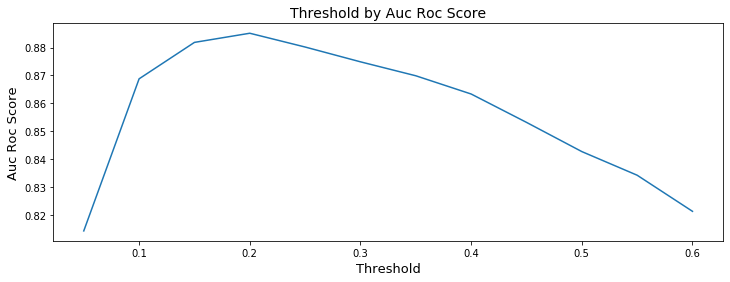

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



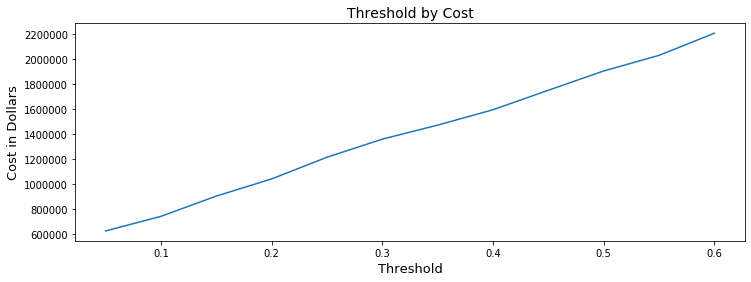

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.814188      622500   81  18975
1        0.10       0.868767      739260  179  10113
2        0.15       0.881840      901360  257   6518
3        0.20       0.885123     1039020  316   4551
4        0.25       0.880179     1212640  382   3332
5        0.30       0.874867     1357580  436   2479
6        0.35       0.869862     1469840  477   1942
7        0.40       0.863320     1592980  521   1499
8        0.45       0.853143     1749000  575   1200
9        0.50       0.842659     1903260  628    963
10       0.55       0.834177     2028360  671    768
11       0.60       0.821216     2205480  731    624

The best threshold has been automatically selected and scored below.
roc auc score: 0.8851233675644117

The classification report for the current model is shown below.

              precision    recall  f1

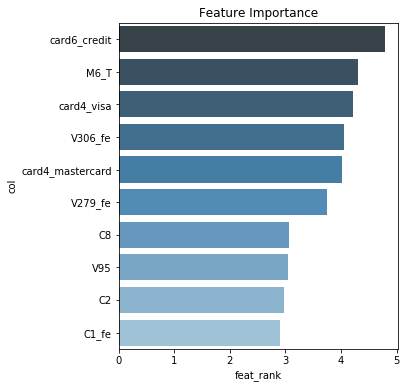


The dataframe represents the top 20 features for this model.

                 col  feat_rank
0       card6_credit   4.782993
1               M6_T   4.299109
2         card4_visa   4.213889
3            V306_fe   4.047015
4   card4_mastercard   4.019379
5            V279_fe   3.751005
6                 C8   3.070859
7                V95   3.048053
8                 C2   2.975448
9              C1_fe   2.894908
10          card2_fe   2.830864
11                C9   2.644127
12               V75   2.336556
13              V312   2.220268
14              V128   2.197224
15               V97   2.159609
16            C14_fe   2.064856
17       card6_debit   2.016344
18              V291   1.886333
19               C13   1.871834


In [37]:
model_current = CatBoostClassifier(random_state=42, verbose=0)
mod.create_df_score_model(model_current)

### CatBoostClassifier - Tuned Model


The following model is being fitted:


The plot below shows the threshold by auc roc score.



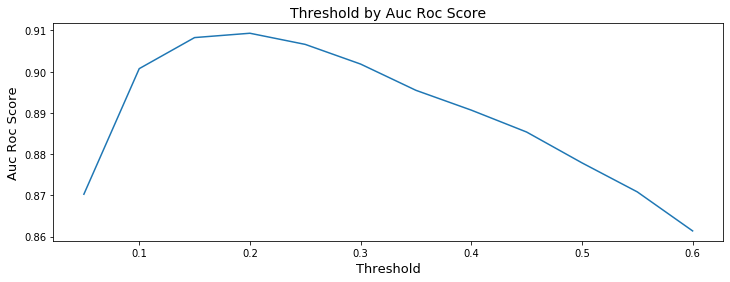

The plot below shows the cost by threshold based
upon the cost of false positive and false negatives.



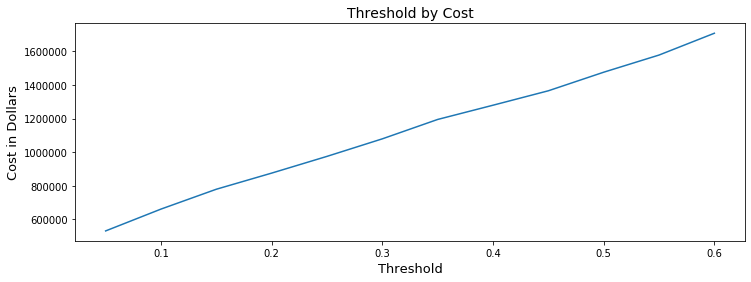

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2

Below are the results by threshold:

    threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.870286      531620   96  12181
1        0.10       0.900736      661520  177   6526
2        0.15       0.908269      779660  232   4183
3        0.20       0.909323      875660  272   2983
4        0.25       0.906618      975300  310   2265
5        0.30       0.901850     1079640  348   1782
6        0.35       0.895484     1195000  389   1400
7        0.40       0.890681     1279740  419   1137
8        0.45       0.885368     1365640  449    932
9        0.50       0.877896     1476140  487    757
10       0.55       0.870853     1578280  522    614
11       0.60       0.861388     1708080  566    504

The best threshold has been automatically selected and scored below.
roc auc score: 0.909322522239418

The classification report for the current model is shown below.

              precision    recall  f1-

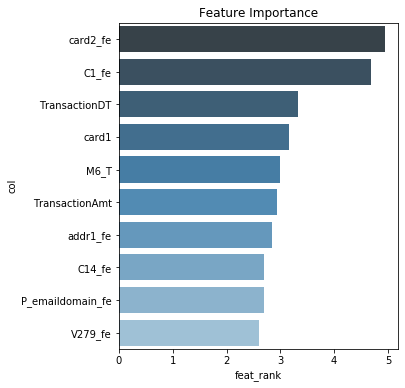


The dataframe represents the top 20 features for this model.

                 col  feat_rank
0           card2_fe   4.938498
1              C1_fe   4.688392
2      TransactionDT   3.323158
3              card1   3.154643
4               M6_T   2.985853
5     TransactionAmt   2.935695
6           addr1_fe   2.837008
7             C14_fe   2.694229
8   P_emaildomain_fe   2.687652
9            V279_fe   2.605678
10               V95   2.568521
11               C13   2.564821
12  card4_mastercard   2.294826
13        card4_visa   2.276083
14                C2   2.103329
15           V306_fe   2.039010
16           V294_fe   1.964952
17      card6_credit   1.911047
18              V304   1.615748
19               V12   1.536123


In [38]:
model_current = CatBoostClassifier(max_depth=10,
                                   random_state=42, 
                                   verbose=0)
mod.create_df_score_model(model_current)